# GeoPandas mit Dask

Nötigenfalls die Python-Bibliotheken installieren:

In [1]:
#!pip install pandas fiona shapely pyproj rtree
#!pip install geopandas
#!pip install pygeos
#!pip install matplotlib
#!pip install pyarrow
#!pip install dask-geopandas

## Shapefile mit GeoPandas einlesen

In [21]:
import pandas as pd
import geopandas as gpd

Mit GeoPandas ist es einfach, Geodaten zu laden, zu bearbeiten und darzustellen.

Hier ein Beispiel mit den Taxizonen von New York:

In [3]:
taxi_zones = gpd.read_file('../data/nyc-taxi-zones/taxi_zones.shp') \
                .to_crs('EPSG:4326')

<AxesSubplot: >

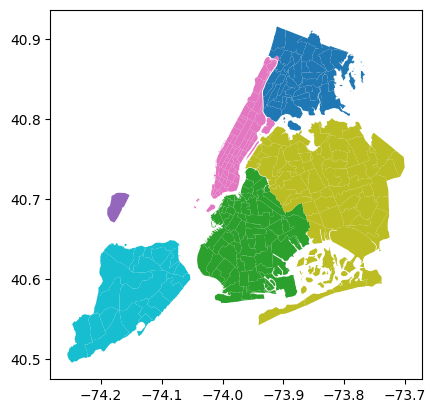

In [4]:
taxi_zones.plot(column = 'borough', categorical = True)

## CSV-Datei mit Geodaten einlesen

In [5]:
import dask.dataframe as dd
import dask_geopandas as dg

Wir laden nun die Datei mit den Taxi Trip Durations aus New York:

In [6]:
taxi_trips = dd.read_csv('../data/nyc-taxi-trip-duration/train.csv')

In [7]:
taxi_trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Wir haben noch keine Geometrie in diesem DataFrame. Das können wir nachholen:

In [8]:
taxi_geom = dg.points_from_xy(
    df = taxi_trips,
    x = 'pickup_longitude',
    y = 'pickup_latitude',
    crs = 'EPSG:4326'
)

In [9]:
taxi_trips_geom = dg.from_dask_dataframe(
    df = taxi_trips,
    geometry = taxi_geom
)

In [10]:
taxi_trips_geom.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,geometry
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,POINT (-73.98215 40.76794)
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,POINT (-73.98042 40.73856)
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,POINT (-73.97903 40.76394)
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,POINT (-74.01004 40.71997)
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,POINT (-73.97305 40.79321)


Wir können nun einen Spatial Join machen zwischen den Taxifahrten und den Taxizonen:

In [11]:
taxi_trips_geom = taxi_trips_geom.set_crs('EPSG:4326')

## Spatial Join

In [12]:
taxi_trips_geom = dg.sjoin(
    taxi_trips_geom,
    taxi_zones
)

In [14]:
taxi_trips_geom.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,geometry,index_right,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,POINT (-73.98215 40.76794),141,142,0.038176,0.000076,Lincoln Square East,142,Manhattan
39,id3720663,1,2016-05-10 16:14:56,2016-05-10 16:40:19,1,-73.977768,40.774078,-73.947144,40.775993,N,1523,POINT (-73.97777 40.77408),141,142,0.038176,0.000076,Lincoln Square East,142,Manhattan
139,id1886740,1,2016-05-29 00:15:12,2016-05-29 00:24:38,1,-73.985115,40.768726,-73.951668,40.774433,N,566,POINT (-73.98512 40.76873),141,142,0.038176,0.000076,Lincoln Square East,142,Manhattan
202,id1372674,2,2016-05-22 13:08:24,2016-05-22 13:21:50,1,-73.978210,40.777161,-73.957626,40.774548,N,806,POINT (-73.97821 40.77716),141,142,0.038176,0.000076,Lincoln Square East,142,Manhattan
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,POINT (-73.98182 40.76896),141,142,0.038176,0.000076,Lincoln Square East,142,Manhattan


Datensatz als Parquet-Datei auf die Festplatte schreiben. Dabei wird mehr als eine Datei geschrieben, da Dask die Daten partitioniert. Die verschiedenen Dateien widergeben diese Partitionierung.

In [ ]:
taxi_trips_geom.to_parquet('nyc-taxi-trips-zones')

## Aggregation

Nun können wir die Anzahl Passagiere pro Taxizone berechnen:

In [17]:
pass_pro_zone = taxi_trips_geom['passenger_count'] \
                    .groupby(taxi_trips_geom.zone) \
                    .count() \
                    .compute()

In [18]:
pass_pro_zone

zone
Allerton/Pelham Gardens                 5
Alphabet City                        4776
Arrochar/Fort Wadsworth                 6
Astoria                              2878
Astoria Park                           19
                                     ... 
Crotona Park                            1
Eltingville/Annadale/Prince's Bay       1
Jamaica Bay                             1
Rockaway Park                           2
Rossville/Woodrow                       1
Name: passenger_count, Length: 248, dtype: int64

In [19]:
pass_pro_zone.name = 'count'

In [22]:
taxi_zones_merged = pd.merge(
    pass_pro_zone.to_frame(),
    taxi_zones,
    left_index = True,
    right_on = 'zone'
)

In [23]:
taxi_zones_merged = gpd.GeoDataFrame(taxi_zones_merged)

<AxesSubplot: >

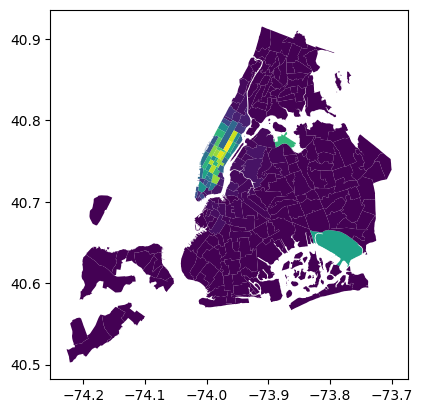

In [25]:
taxi_zones_merged.plot(column = 'count')